In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

In [2]:
climyrs=[1993,2023]
jj=60
qtile=0.90
detr=True
smoothClim=True
smoothTrend=True
meth=method
win=halfwin
qtvar='qt1'
delt=15
lead=5

In [3]:
pathobs=fnameOISSTMHW(climyrs,jj,qtile,smoothClim,meth,win,detr,delt,qtvar)
print(pathobs)

/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/OISST/oisst_MHW__detr_ClimStri10_C1993_2023_q0_90_delt15-avhrr-v02r01.regridded1x1g2.daily.j60_qt1.nc


In [4]:
pathfor=fnameCanESMMHW(workdir,climyrs[0],climyrs[-1],lead,jj,qtile,detr,smoothClim,smoothTrend,meth,win,delt,qtvar)
print(pathfor)

/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/MHWDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_delt15_j060_qt1_q0_90_ocean_1d_surface_tso.nc


In [5]:
iSEDI=compstats(pathfor,pathobs,lead)
iSEDI

compstats: calcSEDI closefiles ffor fobs forfile mhwfor mhwobs obsfile saveSEDI

In [6]:
fout=fnameSEDI_OISST_CanESM_daily(climyrs, smoothClim, meth, win, detr, qtile, delt, qtvar, jj)
fout

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/stats/SEDI_OISST_CanESM_daily_C1993_2023_ClimStri10_detr_0_90_delt15_j060_qt1.nc'

In [7]:
iSEDI.calcSEDI()

In [8]:
iSEDI

compstats: FN FP SEDI TN TP calcSEDI closefiles ffor fobs forfile lmask mhwfor mhwobs obsfile saveSEDI

In [9]:
np.shape(iSEDI.TP)

(60, 360)

In [11]:
iSEDI.saveSEDI(fout)

In [12]:
iSEDI.closefiles()

In [2]:
# open an MHW file
f=xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/'\
                  'MHWDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_delt15_j000_qt1_q0_90_ocean_1d_surface_tso.nc')

In [3]:
fobs=xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/OISST/oisst_MHW__detr_ClimStri10_C1993_2023_q0_90_delt15-avhrr-v02r01.regridded1x1g2.daily.j0_qt1.nc')

In [4]:
f

<xarray.Dataset> Size: 1GB
Dimensions:   (reftime: 378, r: 20, lat: 60, lon: 360)
Coordinates:
    leadtime  timedelta64[ns] 8B ...
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    isMHW     (reftime, r, lat, lon) float64 1GB ...
    MHW_prob  (reftime, lat, lon) float64 65MB ...

In [5]:
fobs

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 12235, lat: 60, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 98kB 1991-01-01T12:00:00 ... 2024-06-30T12...
  * lat      (lat) float32 240B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    isMHW    (time, lat, lon) float64 2GB ...

In [21]:
ilead=5

In [ ]:
tsel=f.reftime.values+np.timedelta64(ilead,'D')
tsel=tsel[tsel<fobs.time.values[-1]]
mhwfor=f['isMHW'].isel(reftime=slice(0,len(tsel))).data
mhwobs=fobs['isMHW'].sel(time=tsel,method='nearest',tolerance=np.timedelta64(12,'h')).data

In [57]:
np.shape(mhwfor),np.shape(mhwobs)

((378, 20, 60, 360), (378, 60, 360))

In [58]:
M=np.shape(mhwfor)[1]
N_pos=np.sum(mhwfor,axis=1)
N_neg=np.sum((mhwfor==0).astype(float),axis=1)
TP=np.where(mhwobs==1,N_pos,0)
TN=np.where(mhwobs==0,N_neg,0)
FP=np.where(mhwobs==0,N_pos,0)
FN=np.where(mhwobs==1,N_neg,0)

In [59]:
# calculate SEDI, summed over time
Nobs_pos=np.sum(mhwobs,axis=0)
Nobs_neg=np.sum(1-mhwobs,axis=0)
F=np.sum(FP,axis=0)/(Nobs_neg*M)
H=np.sum(TP,axis=0)/(Nobs_pos*M)

SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))
lmask=np.logical_or(np.sum(mhwfor[:,0,:,:],axis=0)==0,np.sum(mhwobs,axis=0)==0)

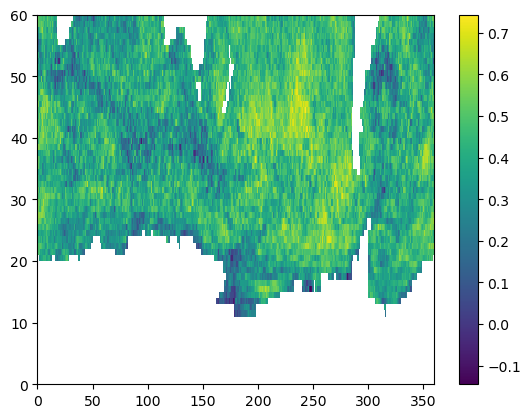

In [40]:
plt.pcolormesh(SEDI); plt.colorbar()

In [60]:

def calc_SEDI(mhwfor,mhwobs):
    # dim 0 must be time
    # mhwfor has extra dim at axis 1: ensemble member
    M=np.shape(mhwfor)[1]
    N_pos=np.sum(mhwfor,axis=1)
    N_neg=np.sum((mhwfor==0).astype(float),axis=1)
    TP=np.where(mhwobs==1,N_pos,0)
    TN=np.where(mhwobs==0,N_neg,0)
    FP=np.where(mhwobs==0,N_pos,0)
    FN=np.where(mhwobs==1,N_neg,0)
    # calculate SEDI, summed over time
    Nobs_pos=np.sum(mhwobs,axis=0)
    Nobs_neg=np.sum(1-mhwobs,axis=0)
    F=np.sum(FP,axis=0)/(Nobs_neg*M)
    H=np.sum(TP,axis=0)/(Nobs_pos*M)
    SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))
    lmask=np.logical_or(np.sum(mhwfor[:,0,:,:],axis=0)==0,np.sum(mhwobs,axis=0)==0)
    return SEDI,lmask

In [61]:
SEDI1,lmask=calc_SEDI(mhwfor,mhwobs)